In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os
os.makedirs('Models', exist_ok=True)

In [2]:
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim=128, in_channel=1):
        super(CNNEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channel, 64, kernel_size=3, padding=1, stride=2), # 1x28x28 -> 64x14x14
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),# 64x14x14 -> 128x7x7
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),# 128x7x7 -> 256x4x4
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            nn.Flatten(), # 256x4x4 -> 4096
            nn.Linear(256 * 4 * 4, latent_dim) # 4096 -> latent_dim = 128
        )

    def forward(self, x):        
        return self.encoder(x)

In [3]:
class CNNDecoder(nn.Module):
    def __init__(self, latent_dim=128, in_channel=1):
        super(CNNDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, in_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(x)

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=128, in_channel=1):
        super(AutoEncoder, self).__init__()
        self.encoder = CNNEncoder(latent_dim, in_channel)
        self.decoder = CNNDecoder(latent_dim, in_channel)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def get_encoder(self):
        """
        Retourne uniquement l'encodeur pour extraire l'espace latent.
        """
        return self.encoder
    def get_decoder(self):
        """
        Retourne uniquement le decodeur.
        """
        return self.decoder

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), # 1x28x28 -> 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(2), # 16x28x28 -> 16x14x14 
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 16x14x14 -> 32x14x14
            nn.ReLU(),
            nn.MaxPool2d(2), # 32x14x14 -> 32x7x7
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32x7x7 -> 64x7x7
            nn.ReLU(),
            nn.MaxPool2d(2), # 64x7x7 -> 64x4x4
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Transformations recommandées
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0,1)
])

In [8]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16045793.99it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 468068.63it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4438325.11it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2492872.12it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

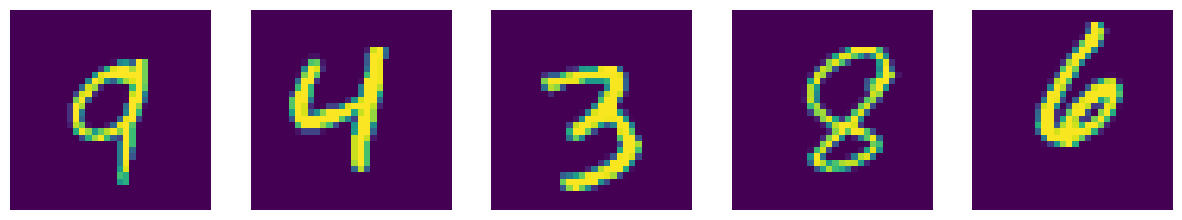

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, _ = train_dataset[i]
    axs[i].imshow(img[0])
    axs[i].axis('off')

In [11]:
batch_size = 32

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Fonction pour afficher les images
def show_images(noisy, original, denoised, num_images=5):
    noisy = noisy.device.detach().numpy()
    original = original.device.detach().numpy()
    denoised = denoised.device.detach().numpy()

    fig, axes = plt.subplots(num_images, 3, figsize=(10, 10))
    for i in range(num_images):
        # Bruité
        axes[i, 0].imshow(noisy[i, 0])
        axes[i, 0].set_title("Noisy")
        axes[i, 0].axis("off")
        
        # Original
        axes[i, 1].imshow(original[i, 0])
        axes[i, 1].set_title("Original")
        axes[i, 1].axis("off")
        
        # Denoisé
        axes[i, 2].imshow(denoised[i, 0])
        axes[i, 2].set_title("Denoised")
        axes[i, 2].axis("off")
    plt.show()

In [14]:
# Ajout de bruit
def add_noise(images, noise_factor=0.7):
    noisy_images = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy_images, 0, 1)

In [15]:
def train_cnn_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10, noisy=0.0, multi_target=False, verbose=True, save_path=None
):
    """
    Entraîne un modèle CNN sur une tâche multi-target.

    Args:
        model: Modèle à entraîner (par ex., auto-encodeur ou réseau de classification)
        train_loader: DataLoader pour les données d'entraînement
        val_loader: DataLoader pour les données de validation
        criterion: Fonction de perte (par ex., MSELoss, BCEWithLogitsLoss)
        optimizer: Optimiseur (par ex., Adam ou SGD)
        num_epochs: Nombre d'époques
        noisy: Coefficient de bruit (0.0 pour désactiver le bruit, >0 pour ajouter du bruit)
        verbose: Si True, affiche les pertes
    
    Returns:
        train_losses: Liste des pertes moyennes par époque sur l'ensemble d'entraînement
        val_losses: Liste des pertes moyennes par époque sur l'ensemble de validation
    """
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        # --- Boucle d'entraînement ---
        if multi_target:
            for img, target in train_loader:
                img, target = img.to(device), target.to(device)
                input = img

                if noisy > 0:
                    input = add_noise(img, noise_factor=noisy)
                
                optimizer.zero_grad()
                output = model(input)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
        else:
            for img, _ in train_loader:
                img = img.to(device)
                input = img

                if noisy > 0:
                    input = add_noise(img, noise_factor=noisy)
                
                optimizer.zero_grad()
                output = model(input)
                loss = criterion(output, img)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)

        # --- Boucle de validation ---
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            if multi_target:
                for img, target in val_loader:
                    img, target = img.to(device), target.to(device)
                    input = img

                    if noisy > 0:
                        input = add_noise(img, noise_factor=noisy)
                    
                    output = model(input)
                    loss = criterion(output, target)
                    epoch_val_loss += loss.item()
            else:
                for img, _ in val_loader:
                    img = img.to(device)
                    input = img

                    if noisy > 0:
                        input = add_noise(img, noise_factor=noisy)
                    
                    output = model(input)
                    loss = criterion(output, img)
                    epoch_val_loss += loss

        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train_Loss: {epoch_loss:.4f}, Val_Loss: {epoch_val_loss:.4f}')

        if save_path is not None:
            torch.save(model.state_dict(), save_path)

    return train_losses, val_losses

In [16]:
# Initialisation du modèle
simple_cnn = SimpleCNN().to(device)

In [17]:
simple_cnn_train_losses, simple_cnn_val_losses = train_cnn_model(
    simple_cnn, 
    train_loader, 
    val_loader, 
    criterion=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(simple_cnn.parameters(), lr=0.001),
    num_epochs=5, 
    noisy=0.0, 
    multi_target=True,
    verbose=True)

Epoch [1/5], Train_Loss: 0.2786, Val_Loss: 0.0990
Epoch [2/5], Train_Loss: 0.0836, Val_Loss: 0.0799
Epoch [3/5], Train_Loss: 0.0602, Val_Loss: 0.0509
Epoch [4/5], Train_Loss: 0.0473, Val_Loss: 0.0442
Epoch [5/5], Train_Loss: 0.0415, Val_Loss: 0.0498


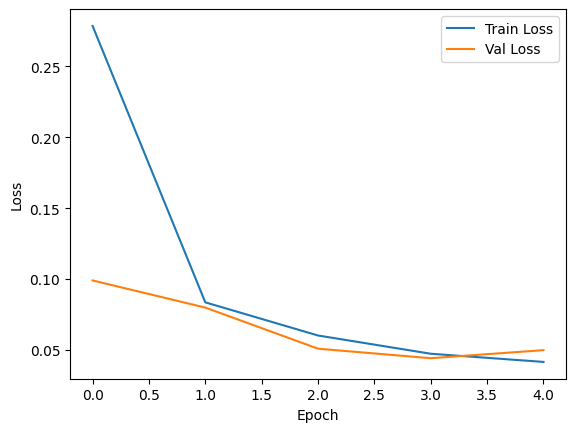

In [18]:
# affichage des courbes de loss
plt.plot(simple_cnn_train_losses, label='Train Loss')
plt.plot(simple_cnn_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
y_true = []
y_pred = []
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = simple_cnn(images)
    _, predicted = output.max(1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

print("\nRapport de Classification sur le jeu de test:")
print(classification_report(y_true, y_pred))
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")


Rapport de Classification sur le jeu de test:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Accuracy: 0.9885


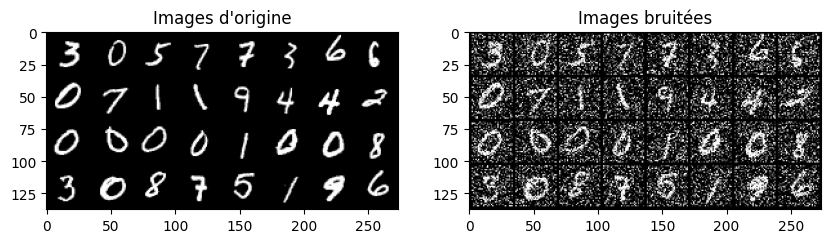

In [20]:
# Visualisation des images avec bruit
images, _ = next(iter(train_loader))
noisy_images = add_noise(images, noise_factor=0.5)

# Affichage
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(torchvision.utils.make_grid(images).permute(1, 2, 0))
axes[0].set_title("Images d'origine")
axes[1].imshow(torchvision.utils.make_grid(noisy_images).permute(1, 2, 0))
axes[1].set_title("Images bruitées")
plt.show()

In [21]:
# Entraînement avec différentes tailles d'espace latent
latent_dims = [64, 128, 256]  # Tailles d'espaces latents
num_epochs = 30
learning_rate = 0.001

results_all = {}  # Dictionnaire pour stocker les pertes des modèles


In [22]:
for latent_dim in latent_dims:
    print(f"--- Entraînement du modèle avec latent_dim={latent_dim} ---")
    
    # Définir le modèle
    model = AutoEncoder(latent_dim=latent_dim, in_channel=train_loader.dataset[0][0].shape[0]).to(device)
    
    # Critère de perte et optimiseur
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Entraînement du modèle
    train_losses, val_losses = train_cnn_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        noisy=0.5,  # Niveau de bruit appliqué
        save_path= f'/kaggle/working/Models/ae_cnn_{latent_dim}.pt'  # Sauvegarde du modèle
    )
    
    
    # Stockage des résultats
    results_all[latent_dim] = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }

    print(f"Modèle avec latent_dim={latent_dim} terminé !\n")

--- Entraînement du modèle avec latent_dim=64 ---
Epoch [1/30], Train_Loss: 0.0753, Val_Loss: 0.0415
Epoch [2/30], Train_Loss: 0.0455, Val_Loss: 0.0387
Epoch [3/30], Train_Loss: 0.0412, Val_Loss: 0.0420
Epoch [4/30], Train_Loss: 0.0390, Val_Loss: 0.0349
Epoch [5/30], Train_Loss: 0.0372, Val_Loss: 0.0335
Epoch [6/30], Train_Loss: 0.0364, Val_Loss: 0.0321
Epoch [7/30], Train_Loss: 0.0352, Val_Loss: 0.0332
Epoch [8/30], Train_Loss: 0.0344, Val_Loss: 0.0310
Epoch [9/30], Train_Loss: 0.0331, Val_Loss: 0.0302
Epoch [10/30], Train_Loss: 0.0330, Val_Loss: 0.0310
Epoch [11/30], Train_Loss: 0.0323, Val_Loss: 0.0301
Epoch [12/30], Train_Loss: 0.0322, Val_Loss: 0.0308
Epoch [13/30], Train_Loss: 0.0314, Val_Loss: 0.0290
Epoch [14/30], Train_Loss: 0.0311, Val_Loss: 0.0341
Epoch [15/30], Train_Loss: 0.0312, Val_Loss: 0.0288
Epoch [16/30], Train_Loss: 0.0304, Val_Loss: 0.0290
Epoch [17/30], Train_Loss: 0.0300, Val_Loss: 0.0291
Epoch [18/30], Train_Loss: 0.0299, Val_Loss: 0.0275
Epoch [19/30], Train_Lo

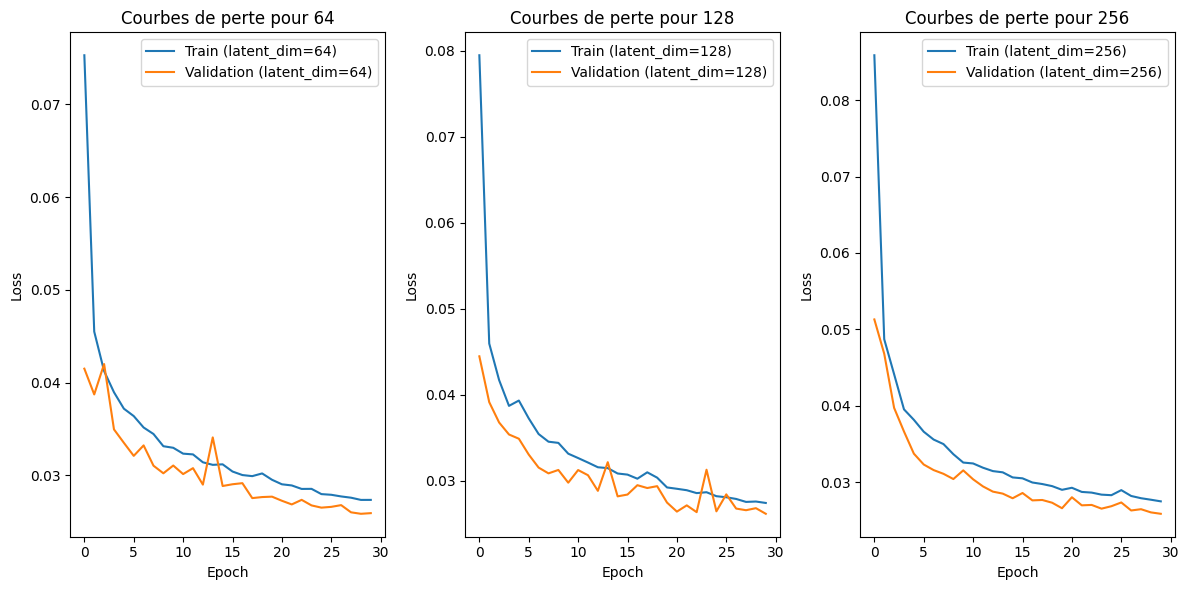

In [23]:
# --- Visualisation des courbes de pertes pour chaque modèle ---
plt.figure(figsize=(12, 6))
for i, latent_dim in enumerate(latent_dims):
    plt.subplot(1, 3, i+1)
    
    # Récupération des pertes pour l'entraînement et la validation
    train_losses = results_all[latent_dim]['train_losses']
    val_losses = results_all[latent_dim]['val_losses']
    
    # Conversion explicite en listes NumPy
    if isinstance(train_losses, torch.Tensor):
        train_losses = train_losses.cpu().numpy()
    elif isinstance(train_losses, list):
        train_losses = np.array([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses])
    
    if isinstance(val_losses, torch.Tensor):
        val_losses = val_losses.cpu().numpy()
    elif isinstance(val_losses, list):
        val_losses = np.array([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses])

    # Tracer les courbes
    plt.plot(train_losses, label=f'Train (latent_dim={latent_dim})')
    plt.plot(val_losses, label=f'Validation (latent_dim={latent_dim})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Courbes de perte pour {latent_dim}')
    plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Fonction pour visualiser les résultats d'un modèle
def visualize_results(model, data_loader, noisy=0.0, num_images=10):
    """
    Visualise les résultats d'un modèle en affichant les images originales, bruitées et reconstruites.
    
    Args:
        model: Le modèle entraîné (par ex., un auto-encodeur)
        data_loader: DataLoader contenant les données à visualiser
        noisy: Coefficient de bruit appliqué aux images
        num_images: Nombre d'images à visualiser
    """
    model.eval()  # Mode évaluation
    fig, axs = plt.subplots(num_images, 3, figsize=(12, num_images * 3))
    
    with torch.no_grad():
        for i, (images, _) in enumerate(data_loader):
            if i >= num_images:
                break
            
            # Prépare les données
            images = images.to(device)
            noisy_images = images
            if noisy > 0:
                noisy_images = add_noise(images, noise_factor=noisy)
            
            # Reconstruction
            outputs = model(noisy_images).cpu()
            print(outputs.shape)
            
            # Déplace les données sur CPU pour affichage
            images = images.cpu()
            noisy_images = noisy_images.cpu()
            
            # Affiche les images originales, bruitées et reconstruites
            for j in range(images.size(0)):
                if j >= num_images:
                    break
                axs[j, 0].imshow(images[j].squeeze(0), cmap="gray")
                axs[j, 0].set_title("Originale")
                axs[j, 1].imshow(noisy_images[j].squeeze(0), cmap="gray")
                axs[j, 1].set_title("Bruitée")
                axs[j, 2].imshow(outputs[j].squeeze(0), cmap="gray")
                axs[j, 2].set_title("Reconstruite")
                
                for ax in axs[j]:
                    ax.axis('off')
            break
    plt.tight_layout()
    plt.show()



--- Visualisation des résultats pour latent_dim=64 ---


/tmp/ipykernel_23/3753592548.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/kaggle/working/Models/ae_cnn_{latent_dim}.pt'))


torch.Size([32, 1, 32, 32])


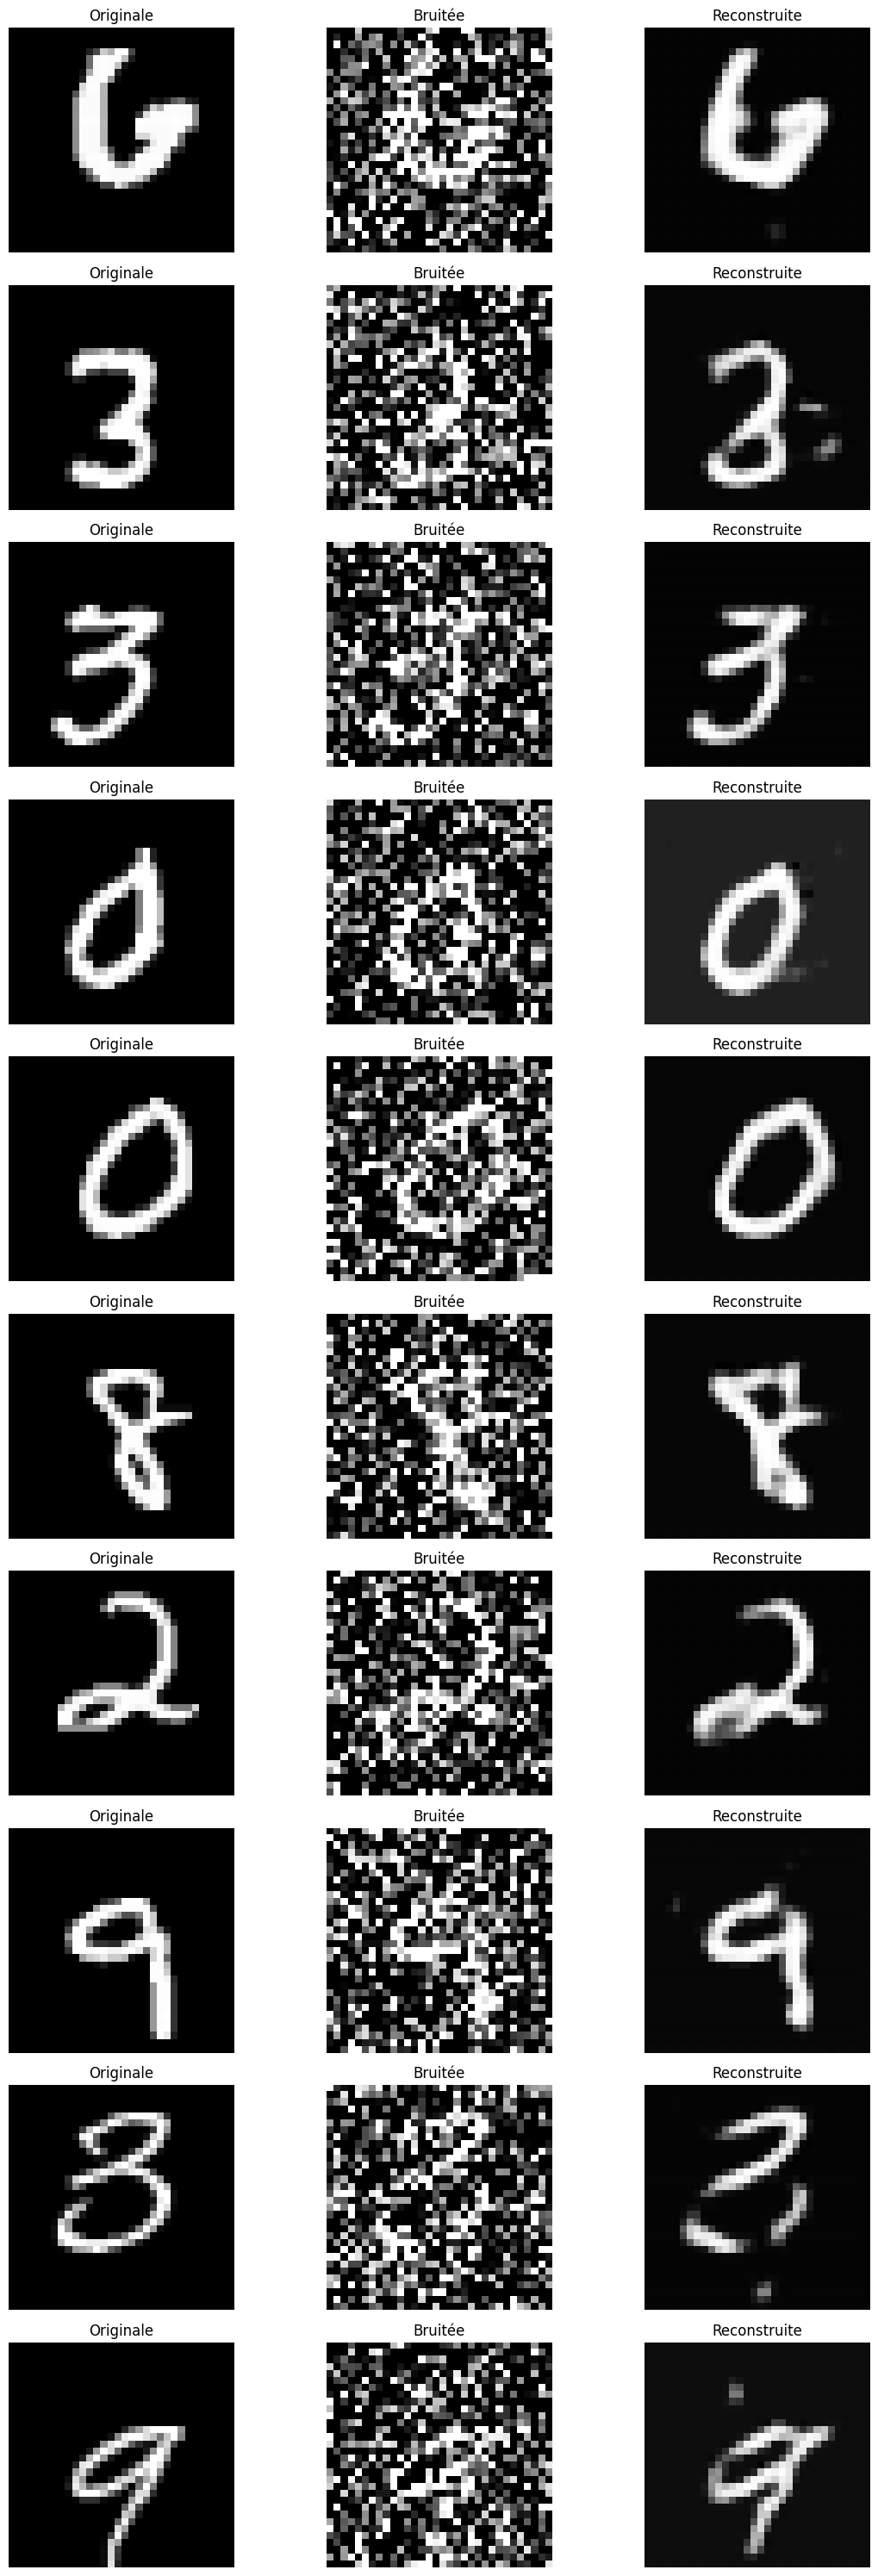

--- Visualisation des résultats pour latent_dim=128 ---
torch.Size([32, 1, 32, 32])


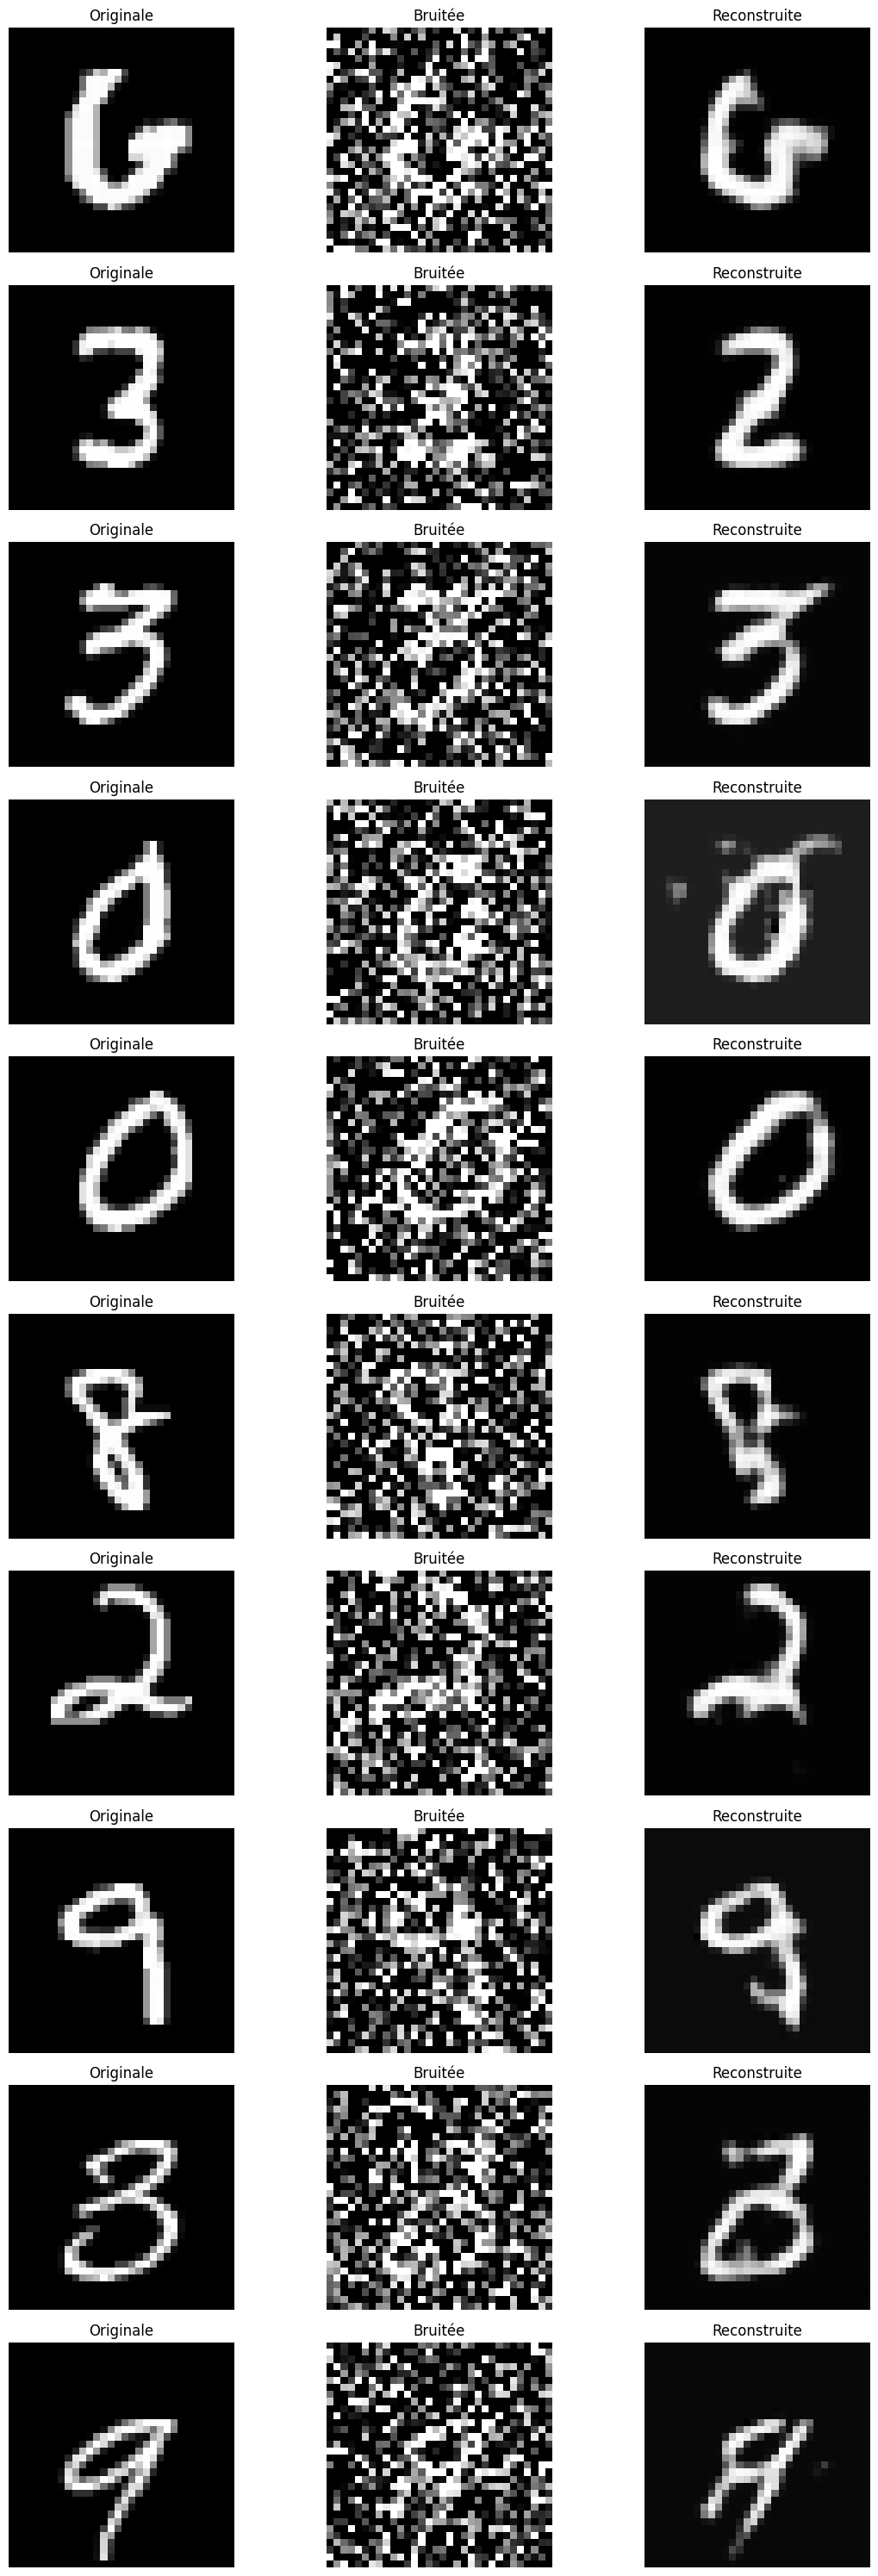

--- Visualisation des résultats pour latent_dim=256 ---
torch.Size([32, 1, 32, 32])


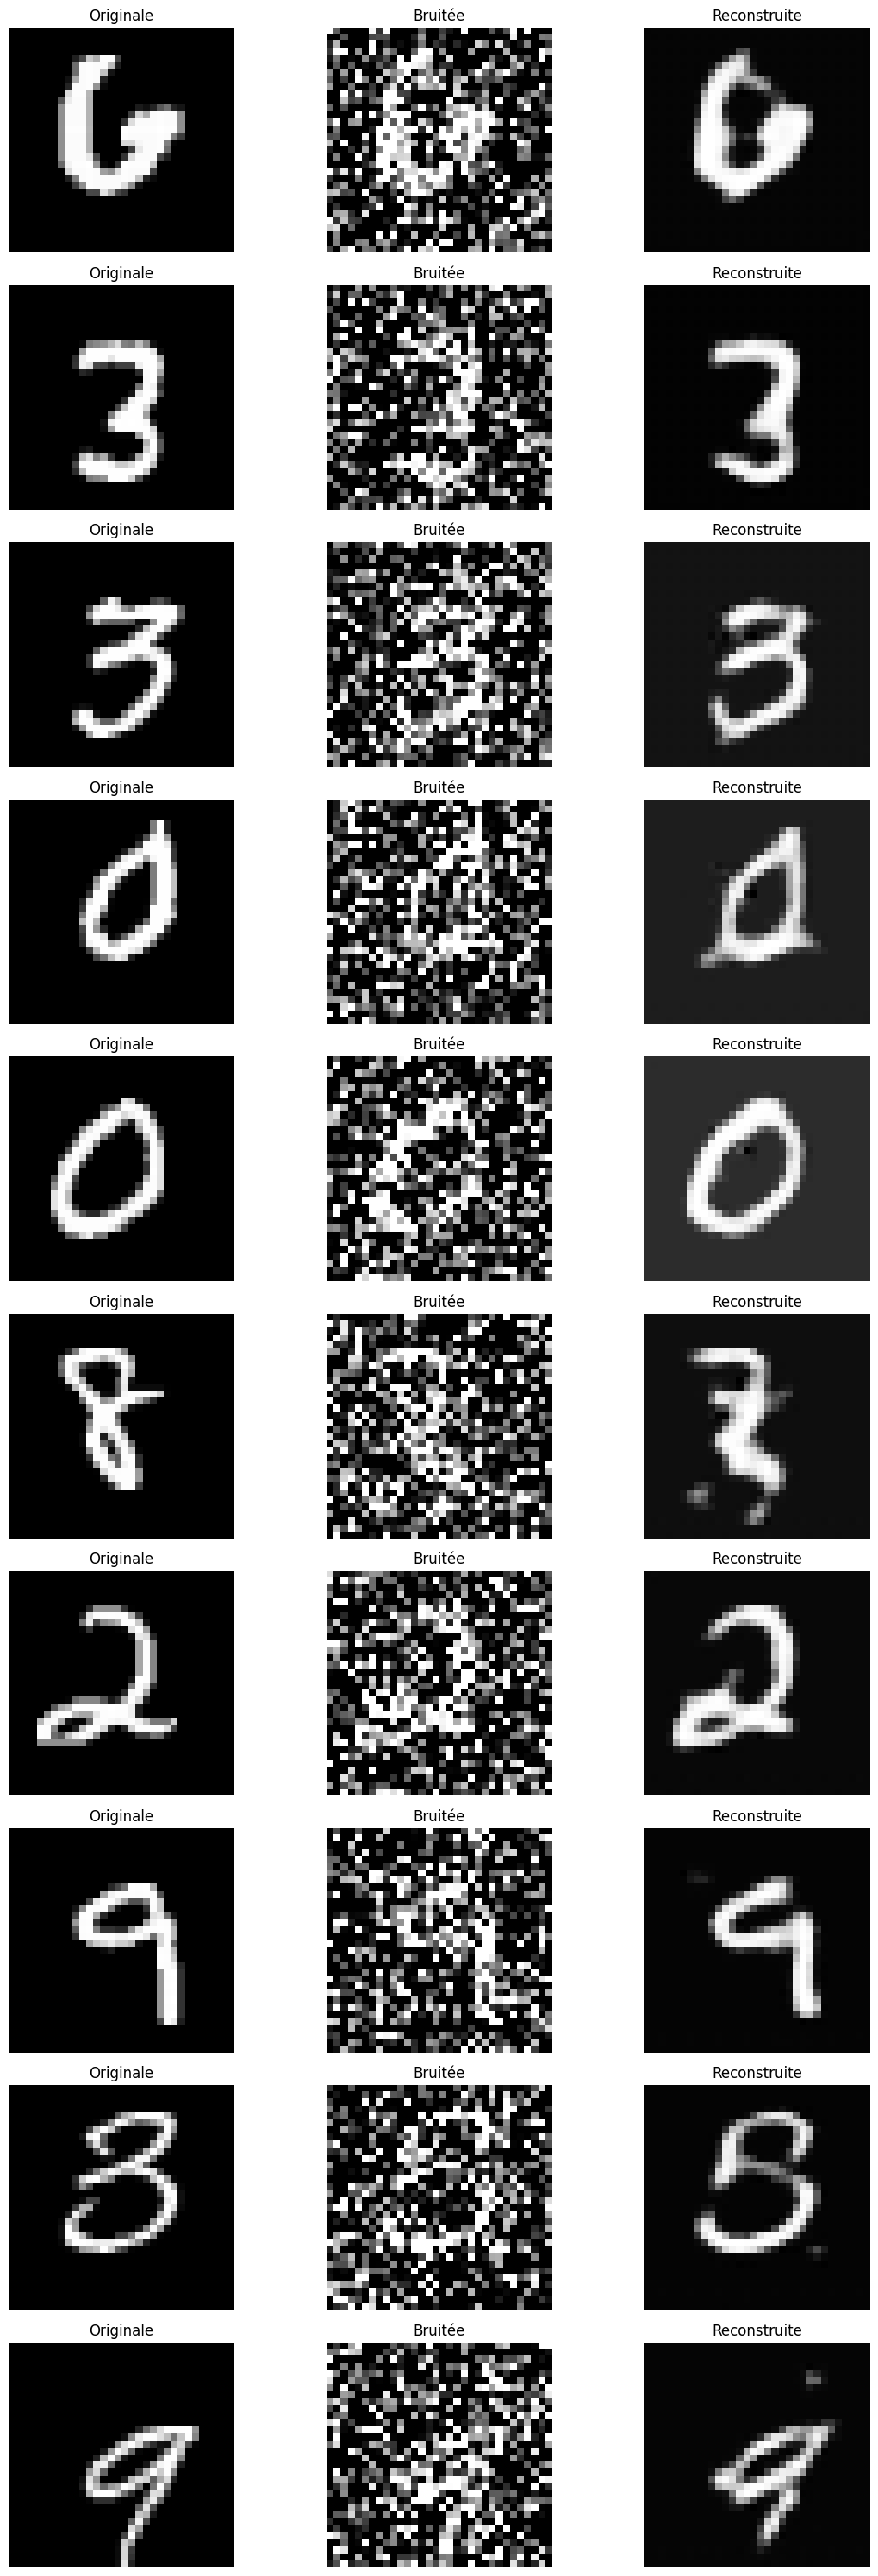

In [25]:
# Visualisation pour chaque modèle
for latent_dim in latent_dims:
    print(f"--- Visualisation des résultats pour latent_dim={latent_dim} ---")
    
    # Charge le modèle entraîné
    model = AutoEncoder(latent_dim=latent_dim, in_channel=train_loader.dataset[0][0].shape[0]).to(device)
    model.load_state_dict(torch.load(f'/kaggle/working/Models/ae_cnn_{latent_dim}.pt'))
    
    # Visualise les résultats
    visualize_results(model=model, data_loader=val_loader, noisy=0.7, num_images=10)

In [26]:
# Chemin du modèle sauvegardé
model_path = '/kaggle/working/Models/ae_cnn_64.pt'

# Dimension de l'espace latent
latent_dim = 64
autoencoder = AutoEncoder(latent_dim=latent_dim, in_channel=1).to(device)

# Charger les poids de l'autoencoder
model_path = '/kaggle/working/Models/ae_cnn_64.pt'
autoencoder.load_state_dict(torch.load(model_path))

autoencoder.eval()

/tmp/ipykernel_23/4268628502.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(model_path))


AutoEncoder(
  (encoder): CNNEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=4096, out_features=64, bias=True)
    )
  )
  (decoder): CNNDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=4096, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(256, 4, 4))
      (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=

In [27]:
# Bruité le dataset de test
noisy_test_loader = []
for images, labels in test_loader:
    noisy_images = add_noise(images, 0.7)
    noisy_test_loader.append((noisy_images, labels))

In [28]:
# Passer les images bruitées dans le modele
y_pred_noisy = []
y_true = []
for images, labels in noisy_test_loader:
    images = images.to(device)
    output = simple_cnn(images)
    _, predicted = torch.max(output, 1)
    y_true.extend(labels.tolist())
    y_pred_noisy.extend(predicted.tolist())

print(classification_report(y_true, y_pred_noisy))
print(f"Accuracy: {accuracy_score(y_true, y_pred_noisy)}")

              precision    recall  f1-score   support

           0       0.91      0.07      0.13       980
           1       0.81      0.01      0.02      1135
           2       0.44      0.36      0.40      1032
           3       0.30      0.81      0.44      1010
           4       0.60      0.10      0.17       982
           5       0.54      0.32      0.40       892
           6       0.97      0.04      0.07       958
           7       0.49      0.14      0.22      1028
           8       0.16      0.84      0.27       974
           9       0.45      0.04      0.07      1009

    accuracy                           0.27     10000
   macro avg       0.57      0.27      0.22     10000
weighted avg       0.57      0.27      0.22     10000

Accuracy: 0.2693


In [29]:
# Passer les images bruitées dans l'autoencodeur
denoised_images = []
for images, labels in noisy_test_loader:
    images = images.to(device)
    denoised = autoencoder(images)
    denoised_images.append((denoised, labels))


# Evaluation
y_true = []
y_pred = []
for images, labels in denoised_images:
    images = images.to(device)
    output = simple_cnn(images)
    _, predicted = torch.max(output, 1)
    y_true.extend(labels.tolist())
    y_pred.extend(predicted.tolist())

print(classification_report(y_true, y_pred))
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       980
           1       0.97      0.88      0.92      1135
           2       0.89      0.91      0.90      1032
           3       0.88      0.92      0.90      1010
           4       0.89      0.85      0.87       982
           5       0.86      0.91      0.88       892
           6       0.95      0.89      0.92       958
           7       0.77      0.95      0.85      1028
           8       0.84      0.85      0.85       974
           9       0.88      0.78      0.83      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy: 0.886


In [30]:
# Passer le jeu de test dans AE puis dans CNN pour prédire
y_true = []
y_pred = []
for images, labels in test_loader:
    images = images.to(device)
    denoised = autoencoder(images)
    output = simple_cnn(denoised)
    _, predicted = torch.max(output, 1)
    y_true.extend(labels.tolist())
    y_pred.extend(predicted.tolist())

print(classification_report(y_true, y_pred))
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.99      0.97      0.98      1010
           4       0.97      0.95      0.96       982
           5       0.97      0.97      0.97       892
           6       0.99      0.97      0.98       958
           7       0.94      0.97      0.95      1028
           8       0.96      0.96      0.96       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy: 0.968


In [31]:
# On va tester la résilience de notre modèle avec différents bruits appliqué sur le jeu de test
type_noise = ['poisson', 'Speckle', 'periodic']

In [32]:
# Fonction pour ajouter différents types de bruit
def add_noise_type(images, noise_type='poisson'):
    noisy_images = []
    for img in images:  # Traiter chaque image individuellement
        if noise_type == 'poisson':
            noisy_img = torch.poisson(img)
        elif noise_type == 'Speckle':
            noisy_img = img + img * torch.randn_like(img)
        elif noise_type == 'periodic':
            noisy_img = img + 0.2 * torch.sin(10 * torch.arange(img.size(1), device=img.device).unsqueeze(0))
        else:
            noisy_img = img
        noisy_images.append(torch.clamp(noisy_img, 0, 1))
    return torch.stack(noisy_images)

In [33]:
# Passer le jeu de test dans AE puis dans CNN pour prédire
for noise in type_noise:
    print(f'--- Test avec le bruit de type {noise} ---')
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Ajouter du bruit
        noisy_images = add_noise_type(images, noise_type=noise)
        
        # Passer dans l'autoencodeur
        denoised = autoencoder(noisy_images)
        
        # Passer dans le CNN
        output = simple_cnn(denoised)
        _, predicted = torch.max(output, 1)
        
        # Ajouter les résultats
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
    
    # Afficher les métriques
    print(classification_report(y_true, y_pred))
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

--- Test avec le bruit de type poisson ---
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       980
           1       0.78      0.94      0.85      1135
           2       0.72      0.79      0.75      1032
           3       0.81      0.78      0.79      1010
           4       0.78      0.68      0.72       982
           5       0.64      0.89      0.74       892
           6       0.89      0.76      0.82       958
           7       0.57      0.89      0.70      1028
           8       0.87      0.55      0.68       974
           9       0.85      0.48      0.61      1009

    accuracy                           0.75     10000
   macro avg       0.78      0.75      0.75     10000
weighted avg       0.78      0.75      0.75     10000

Accuracy: 0.7511
--- Test avec le bruit de type Speckle ---
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       980
           1       0.89      

In [34]:
# Extraire l'encodeur
encoder = autoencoder.get_encoder()
encoder.eval()  # Mettre en mode évaluation

CNNEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=4096, out_features=64, bias=True)
  )
)

In [35]:
def extract_latent_vectors(loader):
    # Extraire les vecteurs latents
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)
    
            # Passer les données dans l'encodeur
            latent_output = encoder(images)
            
            # Stocker les vecteurs latents et les étiquettes
            latent_vectors.append(latent_output.cpu())
            labels.append(targets.cpu())
    
    # Convertir en un Tensor unique
    latent_vectors = torch.cat(latent_vectors, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Latent space shape: {latent_vectors.shape}")

    # Créer un DF pour stocker les vecteurs latents et les étiquettes
    df = pd.DataFrame(latent_vectors.numpy())
    df['labels'] = labels.numpy()
    

    return df

In [36]:
# Extraire les vecteurs latents
train_df = extract_latent_vectors(train_loader)
val_df = extract_latent_vectors(val_loader)
test_df = extract_latent_vectors(test_loader)

Latent space shape: torch.Size([50000, 64])
Latent space shape: torch.Size([10000, 64])
Latent space shape: torch.Size([10000, 64])


In [37]:
from sklearn.preprocessing import StandardScaler

# Extraire X (features) et y (labels) pour chaque dataset
X_train = train_df.drop(columns=['labels']).values
y_train = train_df['labels'].values

X_val = val_df.drop(columns=['labels']).values
y_val = val_df['labels'].values

X_test = test_df.drop(columns=['labels']).values
y_test = test_df['labels'].values

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # On ajuste le scaler sur les données d'entraînement
X_val_scaled = scaler.transform(X_val)         # On applique la même normalisation au jeu de validation
X_test_scaled = scaler.transform(X_test)       # On applique la même normalisation au jeu de test

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Définir et entraîner le SVM avec noyau RBF
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Validation
y_val_pred = svm_model.predict(X_val_scaled)

# Évaluer les performances sur le jeu de validation
print("Validation Results:")
print(classification_report(y_val, y_val_pred))
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred) * 100:.2f}%")

Validation Results:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       993
           1       0.99      0.98      0.99      1154
           2       0.96      0.96      0.96       967
           3       0.95      0.95      0.95      1055
           4       0.95      0.96      0.96       976
           5       0.95      0.96      0.96       944
           6       0.97      0.98      0.98      1002
           7       0.96      0.95      0.95       991
           8       0.96      0.94      0.95       955
           9       0.94      0.93      0.93       963

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Validation Accuracy: 95.94%


In [39]:
# Tester sur le jeu de test
y_test_pred = svm_model.predict(X_test_scaled)

# Évaluer les performances sur le jeu de test
print("Test Results:")
print(classification_report(y_test, y_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")

Test Results:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.94      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.96      0.95      0.96       892
           6       0.97      0.96      0.97       958
           7       0.95      0.94      0.95      1028
           8       0.95      0.95      0.95       974
           9       0.94      0.93      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Test Accuracy: 95.72%


In [40]:
import joblib

# Sauvegarder le modèle SVM
joblib.dump(svm_model, "svm_rbf_model.pkl")

# Charger le modèle sauvegardé
loaded_svm_model = joblib.load("svm_rbf_model.pkl")